# 신용카드 사기 탐지

## 데이터
- 2013년 9월 유럽 카드사용자 (2일간)
- 284,807 거래중 492개의 사기 이용 (0.172%)
- 주성분 분석 (PCA) 데이터만 제공
- 'Time(초)' 과 'Amount' 정보는 제공
- 'Class'는 1이면 사기
- Area Under the Precision-Recall Curve (AUPRC)
- 컨퓨전 매트릭스는 비대칭 데이터 분류의 평가에 적합하지 않음

# EDA

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import keras
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

%tensorflow_version 2.x
%matplotlib inline
plt.rcParams['figure.dpi'] = 75


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
!curl -L https://bit.ly/2nweJrO -o credit.csv.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   147  100   147    0     0    693      0 --:--:-- --:--:-- --:--:--   693
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  1034    0  1034    0     0    676      0 --:--:--  0:00:01 --:--:--  4007
100 65.9M  100 65.9M    0     0  9328k      0  0:00:07  0:00:07 --:--:-- 12.5M


In [3]:
!unzip credit.csv.zip

Archive:  credit.csv.zip
  inflating: creditcard.csv          


In [0]:
data = pd.read_csv('creditcard.csv')

In [5]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## 상관계수 그래프

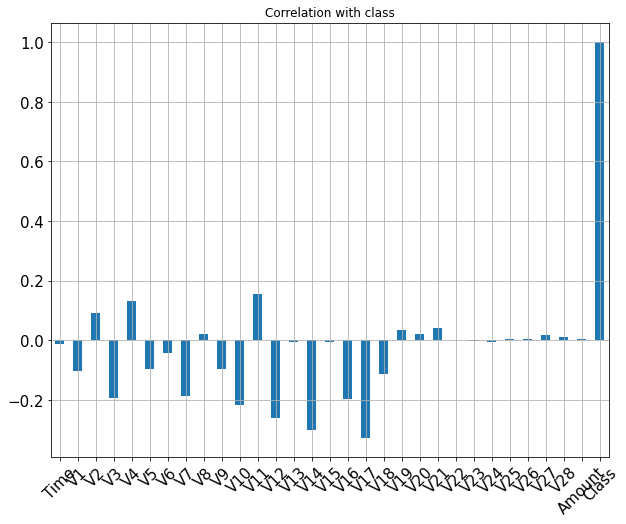

In [7]:
data.corrwith(data.Class).plot.bar(
        figsize = (10,8), title = "Correlation with class", fontsize = 15,
        rot = 45, grid = True)

In [8]:
sn.set(style="white")

# 상관계수
corr = data.corr()
corr.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,1.173963e-01,-1.059333e-02,-4.196182e-01,-1.052602e-01,1.730721e-01,-6.301647e-02,8.471437e-02,-3.694943e-02,-8.660434e-03,3.061663e-02,-2.476894e-01,1.243481e-01,-6.590202e-02,-9.875682e-02,-1.834533e-01,1.190287e-02,-7.329721e-02,9.043813e-02,2.897530e-02,-5.086602e-02,4.473573e-02,1.440591e-01,5.114236e-02,-1.618187e-02,-2.330828e-01,-4.140710e-02,-5.134591e-03,-9.412688e-03,-0.010596,-0.012323
V1,0.117396,1.000000e+00,4.697350e-17,-1.424390e-15,1.755316e-17,6.391162e-17,2.398071e-16,1.991550e-15,-9.490675e-17,2.169581e-16,7.433820e-17,2.438580e-16,2.422086e-16,-2.115458e-16,9.352582e-16,-3.252451e-16,6.308789e-16,-5.011524e-16,2.870125e-16,1.818128e-16,1.036959e-16,-1.755072e-16,7.477367e-17,9.808705e-16,7.354269e-17,-9.805358e-16,-8.621897e-17,3.208233e-17,9.820892e-16,-0.227709,-0.101347
V2,-0.010593,4.697350e-17,1.000000e+00,2.512175e-16,-1.126388e-16,-2.039868e-16,5.024680e-16,3.966486e-16,-4.413984e-17,-5.728718e-17,-4.782388e-16,9.468995e-16,-6.588252e-16,3.854521e-16,-2.541036e-16,2.831060e-16,4.934097e-17,-9.883008e-16,2.636654e-16,9.528280e-17,-9.309954e-16,8.444409e-17,2.500830e-16,1.059562e-16,-8.142354e-18,-4.261894e-17,2.601622e-16,-4.478472e-16,-3.676415e-16,-0.531409,0.091289
V3,-0.419618,-1.424390e-15,2.512175e-16,1.000000e+00,-3.416910e-16,-1.436514e-15,1.431581e-15,2.168574e-15,3.433113e-16,-4.233770e-16,6.289267e-16,-5.501758e-17,2.206522e-16,-6.883375e-16,4.271336e-16,1.122756e-16,1.183364e-15,4.576619e-17,5.427965e-16,2.576773e-16,-9.429297e-16,-2.971969e-17,4.648259e-16,2.115206e-17,-9.351637e-17,4.771164e-16,6.521501e-16,6.239832e-16,7.726948e-16,-0.210880,-0.192961
V4,-0.105260,1.755316e-17,-1.126388e-16,-3.416910e-16,1.000000e+00,-1.940929e-15,-2.712659e-16,1.556330e-16,5.195643e-16,3.859585e-16,6.055490e-16,-2.083600e-16,-5.657963e-16,-1.506129e-16,-8.522435e-17,-1.507718e-16,-6.939204e-16,-4.397925e-16,1.493667e-16,-2.656938e-16,-3.223123e-16,-9.976950e-17,2.099922e-16,6.002528e-17,2.229738e-16,5.394585e-16,-6.179751e-16,-6.403423e-17,-5.863664e-17,0.098732,0.133447


## 히트맵

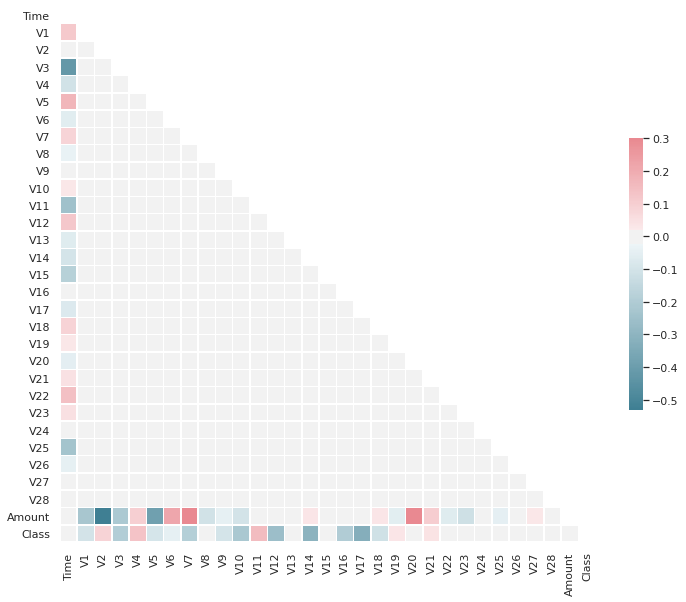

In [9]:
# 하단 부분만 그린다.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 그래프 환경 설정
f, ax = plt.subplots(figsize=(12, 10))
cmap = sn.diverging_palette(220, 10, as_cmap=True)

# 히트맵 그리기
sn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# 스케일링
- min_max, standard, robust
- Standard : 평균이 0, 표준편차가 1이 되도록 변환.
- Robust : 중앙값이 0, IQR이 1이 되도록 변환.
- MinMax : 최대값이 1, 최소값이 0이 되도록 변환.
- MaxAbs : 0을 기준으로 절대값이 가장 큰 수가 1 또는 -1이 되도록 변환.

In [10]:
from sklearn.preprocessing import StandardScaler
data['normalizedAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data[:3]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,normalizedAmount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.244964
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.342475
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.160686


In [11]:
data = data.drop(['Time'],axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,normalizedAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,-0.073403


In [0]:
# X = data.iloc[:, data.columns != ['Class'] | 
X = data.drop(['Amount', 'Class'], axis=1)
y = data.iloc[:, data.columns == 'Class']

In [13]:
X[:3], y[:3]

(         V1        V2        V3  ...       V27       V28  normalizedAmount
 0 -1.359807 -0.072781  2.536347  ...  0.133558 -0.021053          0.244964
 1  1.191857  0.266151  0.166480  ... -0.008983  0.014724         -0.342475
 2 -1.358354 -1.340163  1.773209  ... -0.055353 -0.059752          1.160686
 
 [3 rows x 29 columns],    Class
 0      0
 1      0
 2      0)

In [14]:
X.shape, y.shape

((284807, 29), (284807, 1))

# 모델 훈련

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [16]:
X_train.shape, X_test.shape

((213605, 29), (71202, 29))

## 결정 트리

In [17]:
## 결정 트리
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(splitter='best', min_samples_leaf=1, min_samples_split=2)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [18]:
# 예측치
y_pred = classifier.predict(X_test)
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix: 
[[71037    35]
 [   31    99]]


In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71072
           1       0.74      0.76      0.75       130

    accuracy                           1.00     71202
   macro avg       0.87      0.88      0.87     71202
weighted avg       1.00      1.00      1.00     71202



## 랜덤 포레스트

In [20]:
## 랜덤 포레스트
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


[[71062    10]
 [   27   103]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71072
           1       0.91      0.79      0.85       130

    accuracy                           1.00     71202
   macro avg       0.96      0.90      0.92     71202
weighted avg       1.00      1.00      1.00     71202



# 신경망 모델 (MLP)
- Cross Entropy : 낮은 확률로 예측해서 맞추거나, 높은 확률로 예측해서 틀리는 경우 loss가 더 크게 발생.
- 카테고리가 2개인 경우 binary_crossentropy, 3개 이상인 경우 categorical_crossentropy 사용.

In [21]:
# 신경망 라이브러리
import keras
from keras.models import Sequential
from keras.layers import Dense

classifier = Sequential()
classifier.add(Dense(units = 15 , activation = 'relu', input_dim = 29))
classifier.add(Dense(15, activation = 'relu'))
classifier.add(Dense(1, activation = 'sigmoid'))

# 환경 설정
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# 학습
history = classifier.fit(X_train, y_train, batch_size=20, epochs=10,
                  validation_split=0.25, verbose=1)

# callbacks=[keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)])

Train on 160203 samples, validate on 53402 samples
Epoch 1/10
160203/160203 [==============================] - 38s 234us/step - loss: 0.0093 - accuracy: 0.9987 - val_loss: 0.0033 - val_accuracy: 0.9993
Epoch 2/10
160203/160203 [==============================] - 35s 216us/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.0030 - val_accuracy: 0.9993
Epoch 3/10
160203/160203 [==============================] - 35s 218us/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0031 - val_accuracy: 0.9994
Epoch 4/10
160203/160203 [==============================] - 35s 218us/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0032 - val_accuracy: 0.9994
Epoch 5/10
160203/160203 [==============================] - 35s 215us/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0033 - val_accuracy: 0.9994
Epoch 6/10
160203/160203 [==============================] - 35s 215us/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0037 - val_accuracy: 0.9993
Epoch 7/10
160203/160203 [=================

In [0]:
# 검출 예측
y_pred_score = classifier.predict(X_test)
y_pred = (y_pred_score > 0.5)

In [23]:
print(confusion_matrix(y_test.values, y_pred))

[[71050    22]
 [   24   106]]


In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71072
           1       0.83      0.82      0.82       130

    accuracy                           1.00     71202
   macro avg       0.91      0.91      0.91     71202
weighted avg       1.00      1.00      1.00     71202

